In [1]:
library(stats)
library(survival)
library(tidyverse)
library(readxl)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**The following table (the same as in homework 7) gives a small data set of survival times and a covariate $z$:**

| patient ID | survival time in years | z |
| --- | --- | --- |
| 1 | 7 | 4 |
| 2 | 8 | 3 |
| 3 | 9+ | 5 |
| 4 | 10 | 6 |

**where $+$ means a right censored observation. Assuming a Cox proportional hazards model:**
$$
\lambda(t|z) = \lambda_0(t) e^{\beta z}
$$

In [2]:
data = data.frame(
    patient_id = c(1, 2, 3, 4),
    survival_time = c(7, 8, 9, 10),
    z = c(4, 3, 5, 6),
    observed = c(1, 1, 0, 1)
)

surv = Surv(data$survival_time, data$observed)
surv

[1]  7   8   9+ 10 

**Estimate $H_0(t)$ ($t$ = 7, 8, 10) after Cox model fit by (page 204 in the course notes):**
$$
\hat{H}_0(t) = \sum_{i: \tau_i \le t} ~~ \frac{D_i}{\sum_{j \in R_i } exp(\hat{\beta}z_j)}
$$
**where $D_i$ is the number that failed at that time and $R_i$ is the set of individuals at risk.**

In [3]:
cox_model = coxph(surv ~ z, data = data)
summary(cox_model)

Call:
coxph(formula = surv ~ z, data = data)

  n= 4, number of events= 3 

     coef exp(coef) se(coef)      z Pr(>|z|)
z -0.9030    0.4054   0.8093 -1.116    0.265

  exp(coef) exp(-coef) lower .95 upper .95
z    0.4054      2.467   0.08297      1.98

Concordance= 0.8  (se = 0.16 )
Likelihood ratio test= 1.76  on 1 df,   p=0.2
Wald test            = 1.24  on 1 df,   p=0.3
Score (logrank) test = 1.67  on 1 df,   p=0.2


In [4]:
beta_hat = coef(cox_model)[["z"]]
beta_hat

[1] -0.9029857

In [5]:
data = data %>%
    arrange(survival_time) %>%
    mutate(
        exp_bz = exp(beta_hat * z),
        denom = sum(exp_bz) - cumsum(lag(exp_bz, default = 0)),
        h0_hat = observed / denom,
        H0_hat = cumsum(h0_hat)
    ) %>%
    select(-c(exp_bz, denom, h0_hat))

data

patient_id,survival_time,z,observed,H0_hat
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,4,1,9.175461
2,8,3,1,21.372515
3,9,5,0,21.372515
4,10,6,1,246.781005


**Redo (a) based on Nelson-Aalen estimator (page 94).**

In [6]:
data = data %>%
    mutate(
        at_risk = seq(nrow(data), 1, -1),
        H_NA = cumsum(observed / at_risk)
    ) %>%
    select(-c(at_risk))

data

patient_id,survival_time,z,observed,H0_hat,H_NA
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7,4,1,9.175461,0.2500000
2,8,3,1,21.372515,0.5833333
3,9,5,0,21.372515,0.5833333
4,10,6,1,246.781005,1.5833333


The `H_NA` column is the Nelson-Aalen estimator of the cumulative hazard function.

**Using the WHAS data with 500 subjects (in Week 12 folder), fit Cox proportional hazard models in R. Notice that the survival time and censoring indicator are listed in the last two columns (a readme file in the same folder at the sole site).**

In [7]:
whas = read_excel("whas500.xls") %>%
    select(gender, age, lenfol, fstat) %>%
    rename(
        female = gender,
        days = lenfol,
        died = fstat
    )

head(whas)

female,age,days,died
<dbl>,<dbl>,<dbl>,<dbl>
0,83,2178,0
0,49,2172,0
1,70,2190,0
0,70,297,1
0,70,2131,0
0,70,1,1


In [8]:
whas_surv = Surv(whas$days, whas$died)
whas_cox = coxph(whas_surv ~ 1, data = whas)
summary(whas_cox)

Call:  coxph(formula = whas_surv ~ 1, data = whas)

Null model
  log likelihood= -1227.321 
  n= 500 

**What is the median follow-up of this study?**

In [9]:
quantile(survfit(whas_cox), 0.5)

$quantile
  50 
1671 

$lower
  50 
1527 

$upper
50 
NA

So, the median follow-up of this study is 1671 days, with a 95% lower bound of 1527 days. The upper bound is not observed in the data.

**Plot Kaplan-Meier survival functions (in R) by gender. What is median survival with 95\%CI of each group? What is 1-year (365 days) survival with 95\%CI of each group?**

In [10]:
gender_km = survfit(whas_surv ~ whas$female, data = whas)
gender_km

Call: survfit(formula = whas_surv ~ whas$female, data = whas)

                n events median 0.95LCL 0.95UCL
whas$female=0 300    111   2160    1671      NA
whas$female=1 200    104   1317     905    1627

In [11]:
summary(gender_km, 365.25)

Call: survfit(formula = whas_surv ~ whas$female, data = whas)

                whas$female=0 
        time       n.risk      n.event     survival      std.err lower 95% CI 
     365.250      225.000       75.000        0.750        0.025        0.703 
upper 95% CI 
       0.801 

                whas$female=1 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    365.2500     137.0000      63.0000       0.6850       0.0328       0.6236 
upper 95% CI 
      0.7525 


So,

- The median survival for men was 2160 days, with a 95% CI of (1671, +). The upper bound of the CI was underdetermined in the data.
- The median survival for women was 1317 days, with a 95% CI of (905, 11627).

At one year,
- 75% of men were alive, with a 95% CI of (70.3%, 80.1%)
- 68.5% of women were alive, with a 95% CI of (62.36%, 75.25%)

**Fit a proportional hazard model with gender as a covariate (in R), using (1) exact, (2) Breslow, and (3) Efron for ties, respectively. Please report p-values and state null and alternative hypotheses. Is there big difference on p-vlaues in comparison to the log-rank test?**

The null hypothesis is $H_0: \beta = 0$ and the alternative hypothesis is $H_1: \beta \neq 0$. Here, $\beta$ is the regression coefficient for gender.

In [12]:
whas_cox = coxph(whas_surv ~ whas$female, data = whas, method = "exact")
summary(whas_cox)

Call:
coxph(formula = whas_surv ~ whas$female, data = whas, method = "exact")

  n= 500, number of events= 215 

              coef exp(coef) se(coef)     z Pr(>|z|)   
whas$female 0.3822    1.4655   0.1378 2.775  0.00553 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            exp(coef) exp(-coef) lower .95 upper .95
whas$female     1.466     0.6824     1.119      1.92

Concordance= 0.542  (se = 0.018 )
Likelihood ratio test= 7.61  on 1 df,   p=0.006
Wald test            = 7.7  on 1 df,   p=0.006
Score (logrank) test = 7.79  on 1 df,   p=0.005


In [13]:
whas_cox = coxph(whas_surv ~ whas$female, data = whas, method = "breslow")
summary(whas_cox)

Call:
coxph(formula = whas_surv ~ whas$female, data = whas, method = "breslow")

  n= 500, number of events= 215 

              coef exp(coef) se(coef)     z Pr(>|z|)   
whas$female 0.3813    1.4641   0.1376 2.771  0.00559 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            exp(coef) exp(-coef) lower .95 upper .95
whas$female     1.464      0.683     1.118     1.917

Concordance= 0.542  (se = 0.018 )
Likelihood ratio test= 7.59  on 1 df,   p=0.006
Wald test            = 7.68  on 1 df,   p=0.006
Score (logrank) test = 7.77  on 1 df,   p=0.005


In [14]:
whas_cox = coxph(whas_surv ~ whas$female, data = whas, method = "efron")
summary(whas_cox)

Call:
coxph(formula = whas_surv ~ whas$female, data = whas, method = "efron")

  n= 500, number of events= 215 

              coef exp(coef) se(coef)     z Pr(>|z|)   
whas$female 0.3815    1.4645   0.1376 2.773  0.00556 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            exp(coef) exp(-coef) lower .95 upper .95
whas$female     1.464     0.6828     1.118     1.918

Concordance= 0.542  (se = 0.018 )
Likelihood ratio test= 7.6  on 1 df,   p=0.006
Wald test            = 7.69  on 1 df,   p=0.006
Score (logrank) test = 7.78  on 1 df,   p=0.005


So, the p-values are:
- Exact: 0.00553
- Breslow: 0.00559
- Efron: 0.00556

There is no big difference on p-values in comparison to the log-rank test.


**Redo (c) in SAS (optional).**

No SAS

**Fit a proportional hazard model containing gender, age and the gender-age interaction. Appropriate interpret the model, including the regression parameter $\beta$ for gender, age and the interaction term, respectively. What is the hazard ratio between male and female from this model? What is your interpretation on the hazard ratio from this model?**

In [15]:
whas_cox_interaction = coxph(whas_surv ~ female * age, data = whas)
summary(whas_cox_interaction)

Call:
coxph(formula = whas_surv ~ female * age, data = whas)

  n= 500, number of events= 215 

                coef exp(coef)  se(coef)      z Pr(>|z|)    
female      2.333732 10.316375  0.992674  2.351   0.0187 *  
age         0.078540  1.081707  0.008027  9.785   <2e-16 ***
female:age -0.030502  0.969958  0.012541 -2.432   0.0150 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
female        10.316    0.09693    1.4742   72.1926
age            1.082    0.92446    1.0648    1.0989
female:age     0.970    1.03097    0.9464    0.9941

Concordance= 0.734  (se = 0.018 )
Likelihood ratio test= 148.2  on 3 df,   p=<2e-16
Wald test            = 119.5  on 3 df,   p=<2e-16
Score (logrank) test = 127.7  on 3 df,   p=<2e-16


The $\beta$ for gender is 2.333732. The hazard ratio is 10.316.

In the model, women show significantly higher hazard than men when controlling for age (HR = 10.316, p = 0.0187). An increment of 1 year in age is associated with a factor of 1.082 increase in hazard ratio (p < 0.001). This small per age increase can compound to large differences in hazard ratio for large differences in age. The interaction term was statistically significant (p = 0.015), indicating that the hazard ratio for women increases more slowly with age.

**Plot the predicted survival functions for the following subgroups: (1) male at age 60, (2) male at age 80, (3) female at age 60, and (4) female at age 80. What is median survival and 95\%CI in each subgroup?**

In [16]:
fake_data = data.frame(
    female = c(0, 0, 1, 1),
    age = c(60, 80, 60, 80)
)
sf = survfit(whas_cox_interaction, newdata = fake_data)

In [17]:
q = quantile(sf, 0.5)
data.frame(
    unit = c("male age 60", "male age 80", "female age 60", "female age 80"),
    median = c(q$quantile),
    conf.low = c(q$lower),
    conf.high = c(q$upper)
)

unit,median,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>
male age 60,2353,2350,NA
male age 80,670,467,1200
female age 60,2350,2160,NA
female age 80,936,562,1377


This table shows the median survival and 95%CI for each subgroup. Age seems more important than gender in determining survival.

In [18]:
data_raw = tidy(sf)
data = rbind(
    data_raw %>%
        select(time, starts_with("estimate")) %>%
        pivot_longer(cols = starts_with("estimate"), names_to = "variable", values_to = "value"),
    data_raw %>%
        select(time, starts_with("conf.high")) %>%
        pivot_longer(cols = starts_with("conf.high"), names_to = "variable", values_to = "value"),
    data_raw %>%
        select(time, starts_with("conf.low")) %>%
        pivot_longer(cols = starts_with("conf.low"), names_to = "variable", values_to = "value")
) %>%
    mutate(
        unit_num = as.numeric(str_sub(variable, -1)),
        unit = factor(case_when(
            unit_num == 1 ~ "male age 60",
            unit_num == 2 ~ "male age 80",
            unit_num == 3 ~ "female age 60",
            unit_num == 4 ~ "female age 80"
        )),
        variable = factor(ifelse(
            str_detect(variable, "estimate"), "estimate",
            ifelse(str_detect(variable, "conf.high"), "conf.high", "conf.low")
        ))
    ) %>%
    pivot_wider(names_from = variable, values_from = value)

head(data)

time,unit_num,unit,estimate,conf.high,conf.low
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,1,male age 60,0.9952601,0.9988943,0.9916391
1,2,male age 80,0.9774036,0.9932635,0.9617969
1,3,female age 60,0.9921691,0.9984343,0.9859432
1,4,female age 80,0.9796616,0.9940302,0.9655006
2,1,male age 60,0.9904105,0.9960549,0.9847981
2,2,male age 80,0.9547049,0.9773621,0.9325729


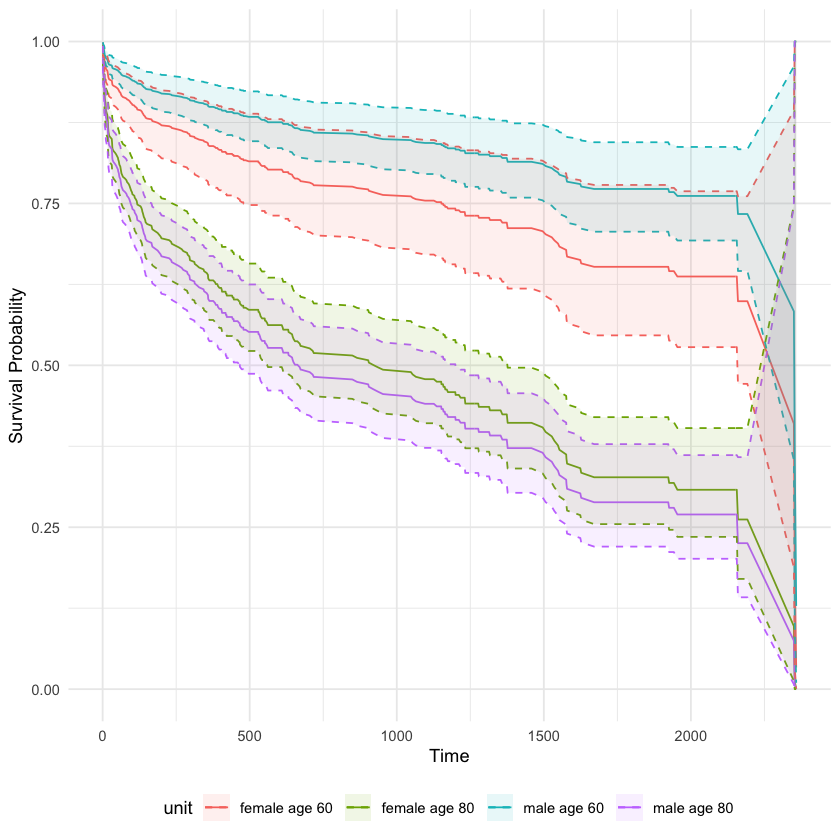

In [19]:
data %>%
    group_by(unit) %>%
    ggplot() +
    geom_line(aes(x = time, y = estimate, color = unit)) +
    geom_line(aes(x = time, y = conf.low, color = unit), linetype = "dashed") +
    geom_line(aes(x = time, y = conf.high, color = unit), linetype = "dashed") +
    geom_ribbon(aes(x = time, ymin = conf.low, ymax = conf.high, fill = unit), alpha = 0.1) +
    labs(x = "Time", y = "Survival Probability") +
    theme_minimal() +
    theme(legend.position = "bottom")

This plot shows predicted survival functions for each subgroup with 95%CI.